In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, copy, os, shutil
import seaborn as sns
import pickle

# for SmoothGrad saliency maps (DO NOT USE MAGNITUDE!)
from gradients import SmoothGrad

# for loading datasets
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST, FashionMNIST

# custom utilities + optimized resnets
import utils
from resnet import resnet20, resnet32, resnet44

# no fancy tricks -- let's keep it simple
train_transforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
batch_size = 256

# create a directory for our figures
if "figures" not in os.listdir():
    os.mkdir("figures")
    
# subdirectory for our qualitative figures
if "quantitative" not in os.listdir("figures"):
    os.mkdir("figures/quantitative")
    
# DO NOT USE GPU FOR SALIENCY MAPS
device = torch.device("cpu")
    
# friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# command-line arguments - let's go 10 IMAGES PER CLASS
dataset = "MNIST" # ["MNIST", "FashionMNIST", "CIFAR10"][int(sys.argv[1])] # either 0, 1, or 2
difficulty_val = "easiest" # ["easiest", "hardest", "overall"][int(sys.argv[2])] # either 0, 1, or 2
split_val = "train" # ["train", "test"][int(sys.argv[3])] # either 0 or 1
class_label_val = 0 # int(sys.argv[4]) # either 0, 1, 2, ..., or 9
batch_idx = 0 # int(sys.argv[5]) # either 0, 1, 2, ..., or 9

# MNIST

In [127]:
# load the appropriate dataset + scores
if dataset == "MNIST":

    # load our training and test data
    data_train = MNIST(root="./data", train=True, download=True, transform=train_transforms)
    data_test = MNIST(root="./data", train=False, download=True, transform=train_transforms)

    # load in our log files too
    train_scores = pd.read_csv("logs/mnist_train_scores.csv")
    test_scores = pd.read_csv("logs/mnist_test_scores.csv")
    
elif dataset == "FashionMNIST":
    
    # load our training and test data
    data_train = FashionMNIST(root="./data", train=True, download=True, transform=train_transforms)
    data_test = FashionMNIST(root="./data", train=False, download=True, transform=train_transforms)

    # load in our log files too
    train_scores = pd.read_csv("logs/fashion-mnist_train_scores.csv")
    test_scores = pd.read_csv("logs/fashion-mnist_test_scores.csv")
    
elif dataset == "CIFAR10":
    
    # load our training and test data
    data_train = CIFAR10(root="./data", train=True, download=True, transform=train_transforms)
    data_test = CIFAR10(root="./data", train=False, download=True, transform=train_transforms)

    # load in our log files too
    train_scores = pd.read_csv("logs/cifar10_train_scores.csv")
    test_scores = pd.read_csv("logs/cifar10_test_scores.csv")

# compute the difficulties of each train and test point
train_difficulties = train_scores[train_scores.columns[4:]].mean(axis=0).values
test_difficulties = test_scores[test_scores.columns[4:]].mean(axis=0).values

In [128]:
# set a seed
np.random.seed(858)
torch.manual_seed(858)

# how many images are we looking at per class?
N_SAMPLES = 100

# are we looking at easiest, hardest, or overall?
for difficulty in [difficulty_val]:

    # go thru both train + test splits
    for split in [split_val]:
        
        # create our subplots here!
    
        # go thru each of our classes
        for class_label in [class_label_val]:

            # get the N_SAMPLES images that correspond to difficulty + class_label + split
            if split == "train":
                
                # query all data points + difficulties corres. to this class, pick our N_SAMPLES
                if dataset == "CIFAR10":
                    class_idxs = np.argwhere(np.array(data_train.targets) == class_label).flatten()
                else:
                    class_idxs = np.argwhere(data_train.targets.numpy() == class_label).flatten()
                class_train_difficulties = train_difficulties[class_idxs]
                
                # pick our indices
                if difficulty == "hardest":
                    class_sample_idxs = class_idxs[np.argsort(class_train_difficulties)][:N_SAMPLES]
                elif difficulty == "easiest":
                    class_sample_idxs = class_idxs[np.argsort(class_train_difficulties)][-N_SAMPLES:]
                elif difficulty == "overall":
                    class_sample_idxs = np.random.choice(class_idxs, size=N_SAMPLES, replace=False)
                    
            elif split == "test":
                
                # query all data points + difficulties that correspond to this class
                if dataset == "CIFAR10":
                    class_idxs = np.argwhere(np.array(data_test.targets) == class_label).flatten()
                else:
                    class_idxs = np.argwhere(data_test.targets.numpy() == class_label).flatten()
                class_test_difficulties = test_difficulties[class_idxs]
                
                # pick our indices
                if difficulty == "hardest":
                    class_sample_idxs = class_idxs[np.argsort(class_test_difficulties)][:N_SAMPLES]
                elif difficulty == "easiest":
                    class_sample_idxs = class_idxs[np.argsort(class_test_difficulties)][-N_SAMPLES:]
                elif difficulty == "overall":
                    class_sample_idxs = np.random.choice(class_idxs, size=N_SAMPLES, replace=False)
                
            # go thru each of our images + compute the 450 saliency maps on this batch of 10 images!
            for class_sample_idx in class_sample_idxs[batch_idx*10:(batch_idx*10)+10]:
                
                # get the image that we should be working with, reshape + move to GPU
                img = data_train[class_sample_idx][0] if split == "train" else data_test[class_sample_idx][0]
                img = img.reshape(1, *img.shape)
                img = img.to(device)
                
                # for CIFAR10, we need CNN(25, 47, 100), RESNET(20,32,44)
                if dataset == "CIFAR10":
                    model_packs = [(utils.CIFAR_CNN25K(), "cnn_params=025k"), 
                                   (utils.CIFAR_CNN47K(), "cnn_params=047k"),
                                   (utils.CIFAR_CNN100K(), "cnn_params=100k"),
                                   (resnet20(), "resnet_variant=20"),
                                   (resnet32(), "resnet_variant=32"),
                                   (resnet44(), "resnet_variant=44")]
                
                # for MNIST + FashionMNIST, generate saliencies for all 9 models MLP(1,2,3), CNN(2,3,4), RESNET(20,32,44)
                elif dataset != "CIFAR10":
                    model_packs = [(utils.MNIST_MLP(num_layers=1, data_dim=1024), "mlp_num-layers=1"), 
                                   (utils.MNIST_MLP(num_layers=2, data_dim=1024), "mlp_num-layers=2"),
                                   (utils.MNIST_MLP(num_layers=3, data_dim=1024), "mlp_num-layers=3"),
                                   (utils.MNIST_CNN(num_modules=2), "cnn_num-modules=2"), 
                                   (utils.MNIST_CNN(num_modules=3), "cnn_num-modules=3"),
                                   (utils.MNIST_CNN(num_modules=4), "cnn_num-modules=4"),
                                   (resnet20(), "resnet_variant=20"),
                                   (resnet32(), "resnet_variant=32"),
                                   (resnet44(), "resnet_variant=44")]
                    
                    

                # create a dictionary for the STACKED saliency maps for each of our 9x models
                saliency_maps = {}

                # go thru all 6x or 9x of our models, all 50 seeds apiece
                for model, model_desc in model_packs:

                    # create an entry in our dictionary for this model + iterate thru the seeds
                    saliency_maps[model_desc] = []
                    for seed in range(50):

                        # load in the correct weights + set to eval mode
                        model.load_state_dict(torch.load(f"models/{dataset}/{model_desc}_seed={str(seed).zfill(3)}/099.pth", 
                                                         map_location="cpu"))
                        model.eval(); model.to(device)

                        # compute our SmoothGrad saliency map, accounting for resnet dimensions
                        smooth_grad = SmoothGrad(pretrained_model=model, cuda=False, n_samples=50, magnitude=False)
                        if ("resnet" in model_desc) and (dataset != "CIFAR10"):
                            saliency_map = smooth_grad(torch.cat([img, img, img], dim=1), index=None)
                        else:
                            saliency_map = smooth_grad(img, index=None)
                        saliency_map_2d = np.sum(saliency_map, axis=0)

                        # add to our dictionary
                        saliency_maps[model_desc].append(copy.deepcopy(saliency_map_2d))

                # save our object as a .pickle so that we can load it for analyses later
                with open(f"maps/{dataset}/{fname}", "wb") as file:
                    pickle.dump(obj=saliency_maps, file=file)

  0%|          | 0/9 [00:00<?, ?it/s]

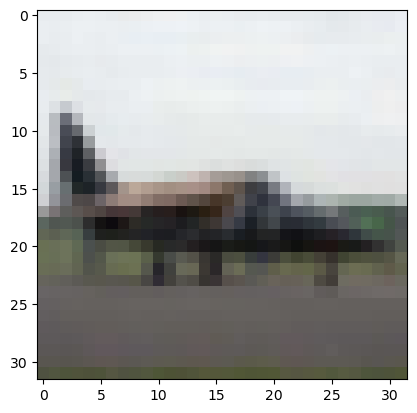

In [122]:
plt.imshow(np.transpose(data_train[class_sample_idx][0].numpy(), (1, 2, 0)))

In [125]:
sorted(os.listdir("models/MNIST"))

['cnn_num-modules=2_seed=000',
 'cnn_num-modules=2_seed=001',
 'cnn_num-modules=2_seed=002',
 'cnn_num-modules=2_seed=003',
 'cnn_num-modules=2_seed=004',
 'cnn_num-modules=2_seed=005',
 'cnn_num-modules=2_seed=006',
 'cnn_num-modules=2_seed=007',
 'cnn_num-modules=2_seed=008',
 'cnn_num-modules=2_seed=009',
 'cnn_num-modules=2_seed=010',
 'cnn_num-modules=2_seed=011',
 'cnn_num-modules=2_seed=012',
 'cnn_num-modules=2_seed=013',
 'cnn_num-modules=2_seed=014',
 'cnn_num-modules=2_seed=015',
 'cnn_num-modules=2_seed=016',
 'cnn_num-modules=2_seed=017',
 'cnn_num-modules=2_seed=018',
 'cnn_num-modules=2_seed=019',
 'cnn_num-modules=2_seed=020',
 'cnn_num-modules=2_seed=021',
 'cnn_num-modules=2_seed=022',
 'cnn_num-modules=2_seed=023',
 'cnn_num-modules=2_seed=024',
 'cnn_num-modules=2_seed=025',
 'cnn_num-modules=2_seed=026',
 'cnn_num-modules=2_seed=027',
 'cnn_num-modules=2_seed=028',
 'cnn_num-modules=2_seed=029',
 'cnn_num-modules=2_seed=030',
 'cnn_num-modules=2_seed=031',
 'cnn_nu

In [75]:
# for MNIST + FashionMNIST, generate saliencies for all 9 models MLP(1,2,3), CNN(2,3,4), RESNET(20,32,44)
model_packs = [(utils.MNIST_MLP(num_layers=1, data_dim=1024), "mlp_num-layers=1"), 
               (utils.MNIST_MLP(num_layers=2, data_dim=1024), "mlp_num-layers=2"),
               (utils.MNIST_MLP(num_layers=3, data_dim=1024), "mlp_num-layers=3"), 
               (utils.MNIST_CNN(num_modules=2), "cnn_num-modules=2"), 
               (utils.MNIST_CNN(num_modules=3), "cnn_num-modules=3"),
               (utils.MNIST_CNN(num_modules=4), "cnn_num-modules=4"),
               (resnet20(), "resnet_variant=20"),
               (resnet32(), "resnet_variant=32"),
               (resnet44(), "resnet_variant=44")]

# create a dictionary for the STACKED saliency maps for each of our 9x models
saliency_maps = {}

# go thru all 9x of our models, all 50 seeds apiece
for model, model_desc in tqdm(model_packs):
    
    # create an entry in our dictionary for this model + iterate thru the seeds
    saliency_maps[model_desc] = []
    for seed in range(50):
        
        # load in the correct weights + set to eval mode
        model.load_state_dict(torch.load(f"models/{dataset}/{model_desc}_seed={str(seed).zfill(3)}/099.pth", 
                                         map_location="cpu"))
        model.eval(); model.to(device)
        
        # compute our SmoothGrad saliency map, accounting for resnet dimensions
        smooth_grad = SmoothGrad(pretrained_model=model, cuda=False, n_samples=50, magnitude=False)
        if "resnet" in model_desc:
            saliency_map = smooth_grad(torch.cat([img, img, img], dim=1), index=None)
        else:
            saliency_map = smooth_grad(img, index=None)
        saliency_map_2d = np.sum(saliency_map, axis=0)
        
        # add to our dictionary
        saliency_maps[model_desc].append(copy.deepcopy(saliency_map_2d))
        
# save our object as a .pickle so that we can load it for analyses later
with open(f"maps/{dataset}/{fname}", "wb") as file:
    pickle.dump(obj=saliency_maps, file=file)

  0%|          | 0/9 [00:00<?, ?it/s]

In [94]:
with open(f"maps/{dataset}/{fname}", "wb") as file:
    pickle.dump(obj=saliency_maps, file=file)

In [92]:
fname = f"difficulty={difficulty}_split={split}_class-label={class_label}_idx={str(class_sample_idx).zfill(5)}"

In [86]:
dataset, difficulty, split, class_label, class_sample_idx

('MNIST', 'easiest', 'train', 0, 20731)

In [129]:
for j in range(3):
    print(j)

0
1
2


In [130]:
j

2